In [1]:
# Import numpy for array processing
import numpy as np
# Import matplotlib to display graphs
# and images
import matplotlib.pyplot as plt
# import tensorflow for deep learning 
# utils
import tensorflow as tf
# Import functions and classes from surrounding
# files to load data, train our model, save it to disk,
# do conversions to TFLite, quantization, pruning, and
# other misc. steps in our training pipeline
from utils import set_seed
from plot_utils import plot_eval_results
from converters import Converter
from config import cfg 
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu
from model import save_pruned_model

# Import keras from tensorflow_model_optimization 
# for depth estimation model construction
from tensorflow_model_optimization.python.core.keras.compat import keras

2024-11-19 15:45:44.354390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732056344.365513    8229 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732056344.368889    8229 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 15:45:44.381890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Allow tensorflow to consume all available GPU memory if one is found 
# for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

We got a GPU


In [3]:
# Import our NYU2 data loader
from nyuv2_torch_ds_adapter import get_nyu2_data_generator
import argparse

# Set parameters that will be useful
# for our training pipeline
args = argparse.Namespace()
args.truncate_testset = False
args.crop_size = (640, 480)
args.target_size = cfg.img_size
args.out_fold_ratio = 1
args.is_maxim = False
args.batch_size=cfg.batch_size

# Load the test and training datasets
ds_train = get_nyu2_data_generator(cfg.batch_size, cfg.base_dataset_dir, "nyu2_train.csv",crop_size = (640, 480), scale_size=cfg.img_size)
ds_val = get_nyu2_data_generator(cfg.batch_size, cfg.base_dataset_dir, "nyu2_test.csv", crop_size = (640, 480), scale_size=cfg.img_size)

x_train= next(iter(ds_train))

I0000 00:00:1732056348.863675    8229 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21828 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [4]:
# Show the minimum and maximum pixel values in the first input and depth images
x_train[0].numpy().max(), x_train[0].numpy().min(), x_train[1].numpy().max(), x_train[1].numpy().min()

(1.0, 0.0, 0.99215686, 0.078431375)

Text(0.5, 1.0, 'Depth')

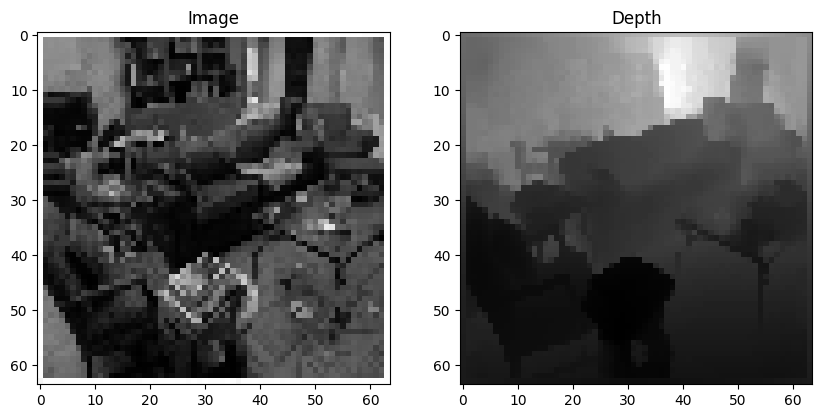

In [5]:
# Plot the example input image and depth map
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_train[0][0].numpy())
axs[1].imshow(x_train[1][0].numpy())
axs[0].set_title('Image')
axs[1].set_title('Depth')

In [6]:
# Set the directories for saving model checkpoints, test data,
# TFLite files, and FlatBuffer files. 
import os
converter = Converter(cfg)

os.makedirs(cfg.save_model_dir, exist_ok=True)
os.makedirs(cfg.save_cfiles_dir, exist_ok=True)
os.makedirs(cfg.save_test_data_dir, exist_ok=True)

In [7]:
# Create model names for different configurations 
# and compression methods
model_names = [
    "depth_model_quant8_dynR",
    "depth_full_quant",
    "depth_qat_int8",
    "pruned_model",
    "pruned_model_unstructured",
    "pruned_model_unstructured_dynamic",
    "pruned_qat_model",
    "depth_model_fp32",
]
cfiles = {
    "depth_model_quant8_dynR": "depth_model_quant8_dynR",
    "depth_full_quant": "q8depth",
    "depth_qat_int8": "qat8depth",
    "pruned_model": "pruned",
    "pruned_model_unstructured": "pruned_unstructured",
    "pruned_model_unstructured_dynamic": "pruned_unstructured_dynamic",
    "pruned_qat_model": "pruned_unstructured_qat_model",
    "depth_model_fp32": "depth_model_fp32",
}

# Save an example input image and depth image to the disk
# for example evaluation
save_test_data(cfg.save_test_data_dir, x_train[0], x_train[1])

Test image data location:  /home/adam-torek/AIHardware_FinalProject/code/test_data/x_test_depth.npy
Test labels location:  /home/adam-torek/AIHardware_FinalProject/code/test_data/y_test_depth.npy


In [8]:
import pickle
from eval import eval_model
from loss import calculate_loss
from model import get_model
import tensorflow_model_optimization as tfmot

"""Function to train and evaluate a depth estimation model 
given a pipeline configuration. This function will construct
the model, train it for a specified number of epochs, and save it
to disk. This function also returns the training history and trained
model weights."""
def fit_eval(model, model_name, do_save_model=True, epochs=cfg.epochs, do_savefig=True):
    # Create a mean over our custom metric for all epochs
    metrics = keras.metrics.Mean(name="loss")

    """Custom metric defined in loss.py. This metric uses depth smoothness,
    SSIM, and per-pixel difference between the target depth image and depth
    estimation to calculate model loss."""
    def custom_metric(y_true, y_pred, sample_weight=None):
        metric_value = calculate_loss(y_true, y_pred)
        metrics.update_state(metric_value, sample_weight=sample_weight)
        return metric_value

    # Use the ADAM optimizer to train our model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    # Compile the given model using the Adam Optimizer
    model.compile(optimizer=optimizer, loss="mae", metrics=[custom_metric])

    # Reducce the learning rate if a loss plateau is detected. 
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.2, min_lr=1e-7, patience=5, min_delta=1e-2, verbose=1
    )
    callbacks = [reduce_lr]

    # Update model pruning if it is enabled
    if "pruned" in model_name:
        callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
    
    # Set up early stopping and checkpointing if overfitting is 
    # turned off
    if not cfg.do_overfit:

        # Create a log of keras callbacks 
        tbCallBack = keras.callbacks.TensorBoard(
            log_dir=f"{cfg.logdir}/tb_logs",
            histogram_freq=0,
            write_graph=False,
            write_images=False,
        )

        # Pre-empt and stop training if the 
        # loss is improving by very little
        es = keras.callbacks.EarlyStopping(
            patience=cfg.es_patience, 
            min_delta=5e-3, 
            monitor="loss",
        )

        # Set up model checkpointing to save the depth estimation
        # model's weights between epochs
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=cfg.logdir + f"/{model_name}" + ".weights.h5",
            save_weights_only=True,
            monitor="custom_metric",
            mode="min",
        )

        # Connect all callbacks to our model's training regime 
        callbacks.append(es)
        callbacks.append(model_checkpoint_callback)
        callbacks.append(tbCallBack)

    # Train the depth estimation model record its performance
    # across all epochs
    history = model.fit(
        x=ds_train,
        epochs=epochs,
        validation_data=ds_val,
        callbacks=callbacks,
        verbose=1,
    )

    # Save the model training history to a python binary file
    with open(f"{cfg.save_model_dir}/{model_name}_history.pkl", "wb") as f:
        pickle.dump(history.history, f)

    # Plot the training history of our depth estimation model
    pu.plot_history(history, f"{cfg.save_model_dir}/{model_name}_history.png")
    if not do_savefig:
        plt.show()
    tflite_path=None
    model_tflite=None
    # Save our trained depth estimation model in both its uncompressed h5
    # and optimized TFLite format
    if do_save_model:
        model.save(f"{cfg.save_model_dir}/{model_name}.h5")
        model_tflite, tflite_path = converter.keras_to_tflite(model, model_name, do_return_path=True)
    # Evaluate the TFLite model to ensure it is performing as expected
    metrics = eval_model(
        model=model,
        test_ds=ds_val,
        tflite_path=tflite_path,
        model_name=model_name,
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )

    # Return the depth estimation model's weights in TFLite format,
    # the evaluation results, and training history
    return model_tflite, metrics, history

In [ ]:
# Build model architecture
fp_model = get_model(
     cfg.img_size, in_channels=cfg.in_channels, use_qat=False,
)
# Train our depth estimation model 
fit_eval(fp_model, model_names[7], epochs=cfg.epochs)
# Save the converted model in both compressed TFLite and uncompressed H5 weight formats
model_tflite, tflite_path = converter.keras_to_tflite(fp_model, model_names[7], do_return_path=True)
write_model_h(cfiles[model_names[7]], model_tflite, cfg.save_cfiles_dir)

Epoch 1/10


I0000 00:00:1732056360.508627    8403 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732056361.359656    8394 service.cc:148] XLA service 0x7e102db72360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732056361.359760    8394 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-19 15:46:01.366548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732056361.424540    8394 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     96/Unknown - 8s 28ms/step - loss: 0.1210 - custom_metric: 0.4175

1/1 [==============================] - 0s 402ms/step
MAE: 0.10, RMSE: 0.02, loss: 0.22


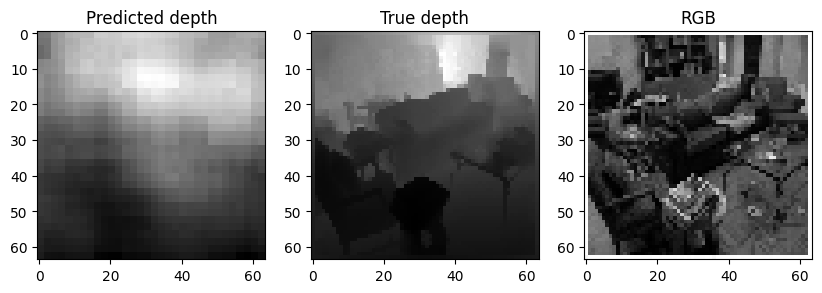

In [ ]:
# Show an example depth prediction from our trained model next
# to the actual depth image and the image itself
out = fp_model.predict(x_train[0][0][None, ...])
plot_eval_results(out[0], x_train[1][0], x_train[0][0])

In [4]:
# Quantize our trained depth estimation model into 8 bit format
dynR_quant_tflite_model = converter.dynamic_range_quantization(fp_model, model_names[0])

NameError: name 'converter' is not defined

In [5]:
# Save the 8-bit quantized model in TFLite format and evaluate 
# the effect of quantization on our model's weights. 
tflite_model_quant_int8=converter.eight_bit_quantization(fp_model, ds_train, model_name=model_names[1])
converter.check_quantized_model(tflite_model_quant_int8)

NameError: name 'converter' is not defined

In [6]:
# perform an evaluation of our depth estimation model in TFLite format
# on the full validation dataset.
depth_full_quant_tflite_path=f'{cfg.save_model_dir}/{model_names[1]}.tflite'
eval_model(
        ds_val,
        tflite_path=depth_full_quant_tflite_path,
        model=None,
        model_name=model_names[1],
        metrics_file_path=f"{cfg.save_model_dir}/metrics.json",
    )
write_model_h(cfiles[model_names[1]], tflite_model_quant_int8, cfg.save_cfiles_dir)

NameError: name 'model_names' is not defined